In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
kernel_size = 4
stride = 1
padding = 0
init_kernel = 16 # initial number of filters

In [146]:
class ConvVAE(nn.Module):
    def __init__(self):
        super(ConvVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Conv2d(
            in_channels=1, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc2 = nn.Conv2d(
            in_channels=init_kernel, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc3 = nn.Conv2d(
            in_channels=init_kernel*2, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc4 = nn.Conv2d(
            in_channels=init_kernel*4, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.enc_mean = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=1, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )

        self.enc_log_var = nn.Conv2d(
            in_channels=init_kernel*8, out_channels=1, kernel_size=kernel_size , 
            stride=stride, padding=padding
        )
        # decoder 
        self.dec1 = nn.ConvTranspose2d(
            in_channels=1, out_channels=init_kernel*8, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_kernel*8, out_channels=init_kernel*4, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_kernel*4, out_channels=init_kernel*2, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_kernel*2, out_channels=init_kernel, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_kernel, out_channels=1, kernel_size=kernel_size, 
            stride=stride, padding=padding
        )
    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5*log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling
        return sample
 
    def forward(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        mu = self.enc_mean(x)
        log_var = self.enc_log_var(x)
        # get `mu` and `log_var`
        
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.relu(self.dec1(z))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        reconstruction = torch.sigmoid(self.dec5(x))
        return reconstruction, mu, log_var

Dans le modèle initial proposé sur le site, mu et log_var prennaient la même valeur. On a réglé ce problème en duplicant la dernière couche de convolution à l'aller. Cependant, le mu et le log_var ainsi codés restent des matrices 2D. Ce qui n'a pas beaucoup de sens vis à vis de notre présentation. L'auteur défend son choix  à la fin de son blog.  Il est préférable de se baser sur notre NoteBook sur MMINST. 

# Notre modèle

In [97]:
model

ConvVAE(
  (enc1): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1))
  (enc2): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1))
  (enc3): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1))
  (enc4): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (enc5): Conv2d(128, 16, kernel_size=(4, 4), stride=(1, 1))
  (dec1): ConvTranspose2d(16, 128, kernel_size=(4, 4), stride=(1, 1))
  (dec2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
  (dec3): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
  (dec4): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(1, 1))
  (dec5): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(1, 1))
)

In [5]:
import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

In [36]:
# get the data into NumPy format
mat_data = scipy.io.loadmat('input/frey_rawface.mat')
data = mat_data['ff'].T.reshape(-1, 1, 28, 20)
data = data.astype('float32') / 255.0
print(f"Number of instances: {len(data)}")

Number of instances: 1965


(1, 28, 20)
(28, 20)


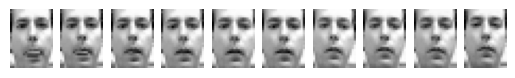

In [49]:
import matplotlib.pyplot as plt
print(data[0].shape)
print(data[0][0].shape)

n_diplay = 10 

fig, axs = plt.subplots(1, n_diplay)

for k in range(n_diplay):
    axs[k].imshow(data[k][0],cmap='gray')
    axs[k].axis('off')


Notre magnifique dataset.

In [10]:
# divide the data into train and validation set
x_train = data[:-300]
x_val = data[-300:]
print(f"Training instances: {len(x_train)}")
print(f"Validation instances: {len(x_val)}")

Training instances: 1665
Validation instances: 300


In [11]:
class FreyDataset(Dataset):
    def __init__(self, X):
        self.X = X
    def __len__(self):
        return (len(self.X))
    def __getitem__(self, index):
        data = self.X[index]
        return torch.tensor(data, dtype=torch.float)

In [13]:
train_data = FreyDataset(x_train)
val_data = FreyDataset(x_val)
# iterable data loader
train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

In [106]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

Notre lowerbound (ici à minimiser).

In [107]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data= data
        data = data.to(device)
        data = data
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [108]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data= data
            data = data.to(device)
            data = data
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], 
                                  reconstruction[:8]))
                save_image(both.cpu(), f"outputs/output{epoch}.png", nrow=num_rows)
    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [152]:
# learning parameters
batch_size = 64
lr = 0.001
epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [147]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [148]:
train_loss = []
val_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 1


27it [00:11,  2.26it/s]                                                                                                                                                                                                                    
5it [00:00,  7.11it/s]                                                                                                                                                                                                                     

Train Loss: 379.2794
Val Loss: 366.4303


Dans le fichier output, on peut voir les différentes images générées en fonction de l'image initiale